In [113]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy.io
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import sklearn.datasets
import re
import seaborn as sns
import datetime as dt
import time
import copy
from tensorflow.python.framework import ops
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import random
import itertools
import logging

#from DNN_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [152]:
# read the preprocessed data
rawdata = pd.read_csv('raw_data.csv')

In [115]:
# split the data
#y = list(rawdata['target'])
#X = rawdata[numCols+catCols]
#train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
#train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,test_size=0.2,random_state=1)


In [153]:
# split the data
y = list(rawdata['target'])
X = rawdata
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,test_size=0.2,random_state=1)
#testdata.to_csv('test.csv')


In [154]:
catCols = ['BorrName', 'BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc','NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState', 'BusinessType'
       ]
numCols = ['BorrZip','CDC_Zip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borrthird','borrpro','borrCDC','total','termint']
numCols = numCols + ['CDC_Zip_dm','ThirdPartyDollars_dm','InitialInterestRate_dm']
train_X = train_X[numCols+catCols]
val_X = val_X[numCols+catCols]
test_X = test_X[numCols+catCols]

In [194]:
# achieved DNN auc 0.81
catCols1 = ['BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState', 'BusinessType'
       ]
numCols1 = ['BorrZip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borrCDC','total','termint']
numCols1 = numCols1 + ['CDC_Zip_dm','ThirdPartyDollars_dm','InitialInterestRate_dm']
train_X1 = train_X[numCols1+catCols1]
val_X1 = val_X[numCols1+catCols1]
test_X1 = test_X[numCols1+catCols1]

train_y1 = copy.deepcopy(train_y)
val_y1 = copy.deepcopy(val_y)
test_y1 = copy.deepcopy(test_y)


In [134]:
# still 0.81
catCols1 = ['BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState'
       ]
numCols1 = ['BorrZip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borrCDC','total']

train_X1 = train_X[numCols1+catCols1]
val_X1 = val_X[numCols1+catCols1]
test_X1 = test_X[numCols1+catCols1]

train_y1 = copy.deepcopy(train_y)
val_y1 = copy.deepcopy(val_y)
test_y1 = copy.deepcopy(test_y)


In [6]:
# try to drop features
catCols1 = ['BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState'
       ]
numCols1 = ['BorrZip','ThirdPartyDollars', 'GrossApproval', 'InitialInterestRate','TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borrCDC','total']

train_X1 = train_X[numCols1+catCols1]
val_X1 = val_X[numCols1+catCols1]
test_X1 = test_X[numCols1+catCols1]

train_y1 = copy.deepcopy(train_y)
val_y1 = copy.deepcopy(val_y)
test_y1 = copy.deepcopy(test_y)


## Baseline: Logistic Regression

In [227]:
# standardization and one-hot encoding
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


model score: 0.864
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7344
           1       0.62      0.42      0.50      1411

   micro avg       0.86      0.86      0.86      8755
   macro avg       0.75      0.68      0.71      8755
weighted avg       0.85      0.86      0.85      8755

0.8401790553216326


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [228]:
print("model score: %.3f" % clf.score(test_X, test_y))
print(classification_report(test_y, clf.predict(test_X)))
print(roc_auc_score(test_y, clf.predict_proba(test_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


model score: 0.869
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      9160
           1       0.65      0.42      0.51      1783

   micro avg       0.87      0.87      0.87     10943
   macro avg       0.77      0.69      0.72     10943
weighted avg       0.85      0.87      0.86     10943

0.8422870536140699


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8422870536140699


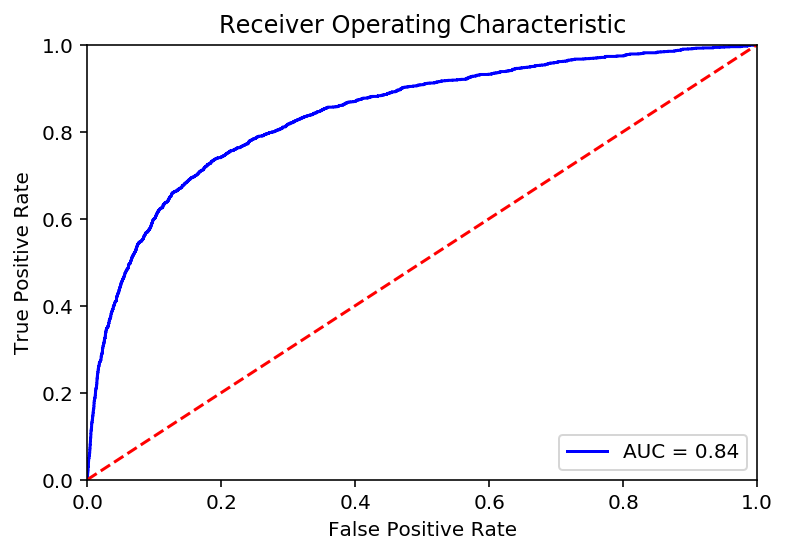

In [229]:
# ROC_AUC curve for logistic regression
probs = clf.predict_proba(test_X)
preds_log = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_y, preds_log)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression with Regularization

#### L1

In [230]:
from sklearn.feature_selection import SelectKBest
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l1'))])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


model score: 0.866
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      7344
           1       0.62      0.43      0.51      1411

   micro avg       0.87      0.87      0.87      8755
   macro avg       0.76      0.69      0.72      8755
weighted avg       0.85      0.87      0.86      8755

0.8430582190353109


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [231]:
print("model score: %.3f" % clf.score(test_X, test_y))
print(classification_report(test_y, clf.predict(test_X)))
print(roc_auc_score(test_y, clf.predict_proba(test_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


model score: 0.868
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      9160
           1       0.65      0.42      0.51      1783

   micro avg       0.87      0.87      0.87     10943
   macro avg       0.77      0.69      0.72     10943
weighted avg       0.85      0.87      0.86     10943

0.8459980174231643


In [232]:
probs = clf.predict_proba(test_X)
preds_log_l1 = probs[:,1]

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Select Features after One-Hot

In [49]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name


In [56]:
coef = clf.named_steps['classifier'].coef_
feature_names = get_column_names_from_ColumnTransformer(clf.named_steps['preprocessor'])
for i in range(len(feature_names)):
    if feature_names[i][0] == 'x':
        flag = i
        break
cat_names = feature_names[flag:]
select = []
for i in range(coef.shape[1]):
    if coef[0,i] != 0:
        select.append(i)
select_features = [feature_names[i] for i in select]
len(select_features)

2307

In [57]:
len(feature_names)

47516

In [14]:
#clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names()

In [15]:
for i in range(len(select_features)):
    if select_features[i][0] == 'x':
        flag = i
        break

In [16]:
num_select = select_features[:flag]
cat_select = select_features[flag:]
inds = []
for i in range(len(cat_select)):
    inds.append(cat_names.index(cat_select[i]))

#### L2

In [233]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l2'))])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


model score: 0.864
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7344
           1       0.62      0.42      0.50      1411

   micro avg       0.86      0.86      0.86      8755
   macro avg       0.75      0.68      0.71      8755
weighted avg       0.85      0.86      0.85      8755

0.8401790553216326


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [234]:
print("model score: %.3f" % clf.score(test_X, test_y))
print(classification_report(test_y, clf.predict(test_X)))
print(roc_auc_score(test_y, clf.predict_proba(test_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


model score: 0.869
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      9160
           1       0.65      0.42      0.51      1783

   micro avg       0.87      0.87      0.87     10943
   macro avg       0.77      0.69      0.72     10943
weighted avg       0.85      0.87      0.86     10943

0.8422870536140699


In [235]:
probs = clf.predict_proba(test_X)
preds_log_l2 = probs[:,1]

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


## Tree Models

### Gradient Boosting

In [5]:
def run_lgbc(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "binary",
        "metric" : "binary_logloss", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)

    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y


In [155]:
modelC, pred_val_y = run_lgbc(train_X, train_y, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.314336
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.313753
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      7344
           1       0.66      0.41      0.50      1411

   micro avg       0.87      0.87      0.87      8755
   macro avg       0.78      0.68      0.71      8755
weighted avg       0.86      0.87      0.86      8755

0.8543494913911702


In [111]:
print(classification_report(test_y, modelC.predict(test_X)>0.5))
print(roc_auc_score(test_y, modelC.predict(test_X)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      9160
           1       0.66      0.39      0.49      1783

   micro avg       0.87      0.87      0.87     10943
   macro avg       0.78      0.68      0.71     10943
weighted avg       0.85      0.87      0.85     10943

0.8565708829385732


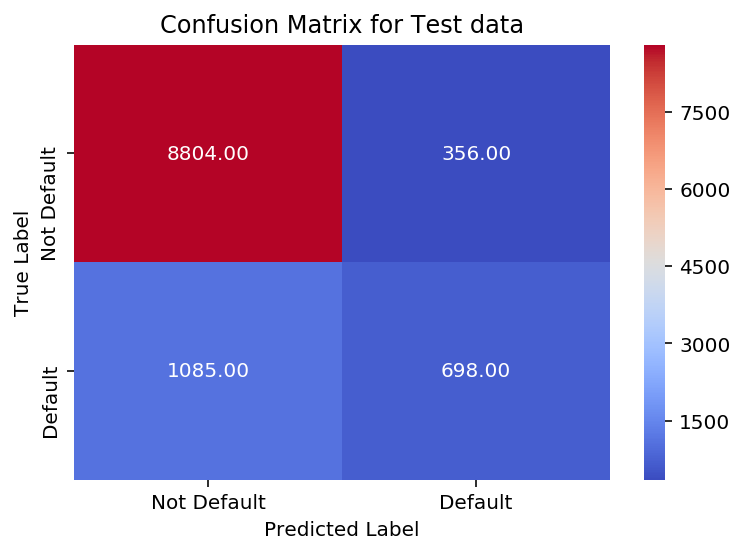

In [23]:
cm_logreg = metrics.confusion_matrix(test_y,modelC.predict(test_X)>0.5)
sns.heatmap(cm_logreg,annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels = ["Not Default", "Default"] , yticklabels = ["Not Default", "Default"])
plt.title("Confusion Matrix for Test data")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [24]:
cm_logreg

array([[8804,  356],
       [1085,  698]], dtype=int64)

In [236]:
preds_lgbm = modelC.predict(test_X)

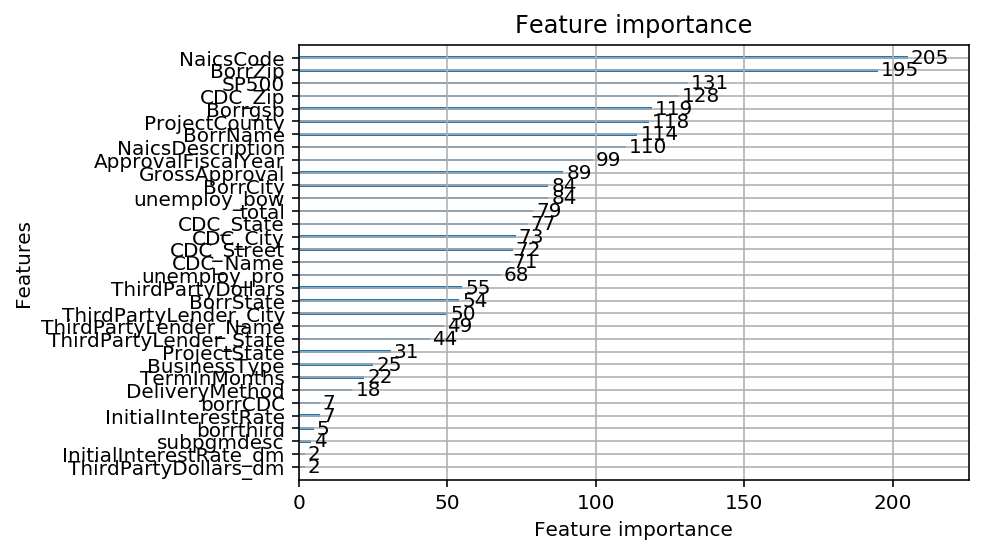

In [26]:
lgb.plot_importance(modelC)

In [27]:
fn = modelC.feature_name()
fi = list(modelC.feature_importance())
for i in range(len(fn)):
    print(fn[i],fi[i])

BorrZip 195
CDC_Zip 128
ThirdPartyDollars 55
GrossApproval 89
InitialInterestRate 7
TermInMonths 22
Borrgsp 119
unemploy_bow 84
unemploy_pro 68
SP500 131
borrthird 5
borrpro 0
borrCDC 7
total 79
termint 0
CDC_Zip_dm 0
ThirdPartyDollars_dm 2
InitialInterestRate_dm 2
BorrName 114
BorrCity 84
BorrState 54
CDC_Name 71
CDC_Street 72
CDC_City 73
CDC_State 77
ThirdPartyLender_Name 49
ThirdPartyLender_City 50
ThirdPartyLender_State 44
ApprovalFiscalYear 99
DeliveryMethod 18
subpgmdesc 4
NaicsCode 205
NaicsDescription 110
ProjectCounty 118
ProjectState 31
BusinessType 25


In [28]:
fm = list(zip(fn,fi))
sorted(fm,key=lambda x:x[1],reverse =True)[:10]

[('NaicsCode', 205),
 ('BorrZip', 195),
 ('SP500', 131),
 ('CDC_Zip', 128),
 ('Borrgsp', 119),
 ('ProjectCounty', 118),
 ('BorrName', 114),
 ('NaicsDescription', 110),
 ('ApprovalFiscalYear', 99),
 ('GrossApproval', 89)]

### Default Rate Prediction on the Best Model

In [132]:
samples = pd.read_csv('samples.csv')
pred_X = samples[numCols+catCols]
# 1 year
pred_y = samples['target1']
pred_prob1 = modelC.predict(pred_X)
print(classification_report(pred_y, modelC.predict(pred_X)>0.5))
print(roc_auc_score(pred_y, modelC.predict(pred_X)))


              precision    recall  f1-score   support

           0       0.98      0.95      0.96       489
           1       0.00      0.00      0.00        11

   micro avg       0.93      0.93      0.93       500
   macro avg       0.49      0.48      0.48       500
weighted avg       0.96      0.93      0.94       500

0.5318832496746607


In [133]:
# 5 year
pred_y = samples['target5']
pred_prob5 = modelC.predict(pred_X)
print(classification_report(pred_y, modelC.predict(pred_X)>0.5))
print(roc_auc_score(pred_y, modelC.predict(pred_X)))


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       461
           1       0.48      0.28      0.35        39

   micro avg       0.92      0.92      0.92       500
   macro avg       0.71      0.63      0.66       500
weighted avg       0.91      0.92      0.91       500

0.7978752989598976


### Select features2

In [32]:
data_scaler = StandardScaler()
train_num = data_scaler.fit_transform(train_X[numCols])
val_num = data_scaler.transform(val_X[numCols])
test_num = data_scaler.transform(test_X[numCols])
train_num_df = pd.DataFrame(train_num,columns = numCols)[num_select]
train_num_df = train_num_df.reset_index(drop=True)
val_num_df = pd.DataFrame(val_num,columns = numCols)[num_select]
val_num_df = val_num_df.reset_index(drop=True)
test_num_df = pd.DataFrame(test_num,columns = numCols)[num_select]
test_num_df = test_num_df.reset_index(drop=True)

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  af

In [33]:
train_cat = train_X[catCols]
one_hot = OneHotEncoder(handle_unknown='ignore')
one_hot.fit(train_cat)
feature_names = [str(i) for i in list(one_hot.get_feature_names())]
for i in range(4):
    if i == 0:
        train_piece = one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds]
        val_piece = one_hot.transform(val_X[catCols]).toarray()[:,inds]
        test_piece = one_hot.transform(test_X[catCols]).toarray()[:,inds]    
    elif i == 3:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[30000:]).toarray()[:,inds]))      
    else:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds]))

train_cat_df = pd.DataFrame(train_piece,columns = cat_select)
val_cat_df = pd.DataFrame(val_piece,columns = cat_select)
test_cat_df = pd.DataFrame(test_piece,columns = cat_select)
newcatCols = list(train_cat_df.columns)

In [34]:
gbtrain_X = pd.concat([train_num_df,train_cat_df],axis = 1)
gbval_X = pd.concat([val_num_df,val_cat_df],axis = 1)
gbtest_X = pd.concat([test_num_df,test_cat_df],axis = 1)

In [35]:
modelS, pred_val_y = run_lgbc(gbtrain_X, train_y, gbval_X, val_y)
print(classification_report(val_y, modelS.predict(gbval_X)>0.5))
print(roc_auc_score(val_y, modelS.predict(gbval_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.313134
[200]	valid_0's binary_logloss: 0.314191
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.312989
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7344
           1       0.67      0.42      0.51      1411

   micro avg       0.87      0.87      0.87      8755
   macro avg       0.78      0.69      0.72      8755
weighted avg       0.86      0.87      0.86      8755

0.8539684014798139


In [36]:
print(classification_report(test_y, modelS.predict(gbtest_X)>0.5))
print(roc_auc_score(test_y, modelS.predict(gbtest_X)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      9160
           1       0.67      0.39      0.50      1783

   micro avg       0.87      0.87      0.87     10943
   macro avg       0.78      0.68      0.71     10943
weighted avg       0.86      0.87      0.86     10943

0.8560020707457869


In [37]:
select2 = []
fn = modelS.feature_name()
fi = list(modelS.feature_importance())
for i in range(len(fn)):
    if fi[i] != 0:
        select2.append(fn[i])
        print(fn[i],fi[i])

BorrZip 223
CDC_Zip 152
ThirdPartyDollars 92
GrossApproval 203
InitialInterestRate 10
TermInMonths 29
Borrgsp 176
unemploy_pro 175
SP500 219
borrthird 15
borrCDC 17
total 163
ThirdPartyDollars_dm 7
InitialInterestRate_dm 12
x1_311 11
x1_520 3
x1_1607 8
x1_2936 3
x1_3369 5
x1_3479 1
x1_3681 3
x1_4069 7
x1_5721 6
x1_5736 1
x1_6659 2
x2_1 7
x2_2 7
x2_4 10
x2_10 15
x2_14 1
x2_16 2
x2_19 7
x2_20 3
x2_21 1
x2_23 13
x2_26 2
x2_28 2
x2_31 1
x2_38 1
x2_39 1
x2_40 1
x2_45 4
x2_50 1
x2_51 10
x3_5 8
x3_22 2
x3_32 1
x3_33 3
x3_35 5
x3_45 2
x3_46 4
x3_47 1
x3_72 1
x3_74 4
x3_93 4
x3_112 8
x3_119 6
x3_125 2
x3_132 1
x3_133 1
x3_141 7
x3_161 2
x3_173 3
x3_178 3
x3_184 5
x3_230 5
x3_231 2
x3_232 3
x3_235 5
x3_242 6
x3_245 1
x3_266 4
x3_275 2
x4_21 1
x4_27 2
x4_42 1
x4_45 1
x4_46 3
x4_55 1
x4_66 1
x4_72 1
x4_88 1
x4_145 1
x4_162 1
x4_182 13
x4_197 1
x4_198 3
x4_203 3
x4_216 3
x4_218 4
x4_221 4
x4_222 1
x4_228 3
x4_233 4
x4_235 1
x4_236 5
x4_245 1
x4_267 1
x4_275 4
x4_284 1
x4_316 1
x4_321 3
x4_329 3
x5_

In [38]:
len(select2)

302

In [39]:
for i in range(len(fn)):
    if feature_names[i][0] == 'x':
        flag = i
        break
cat_names2 = fn[flag:]
for i in range(len(select2)):
    if select2[i][0] == 'x':
        flag = i
        break
num_select2 = select2[:flag]
cat_select2 = select2[flag:]
inds2 = []
for i in range(len(cat_select2)):
    inds2.append(cat_names2.index(cat_select2[i]))

In [40]:
fm = list(zip(fn,fi))
fm1 = sorted(fm,key=lambda x:x[1],reverse =True)[:10]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

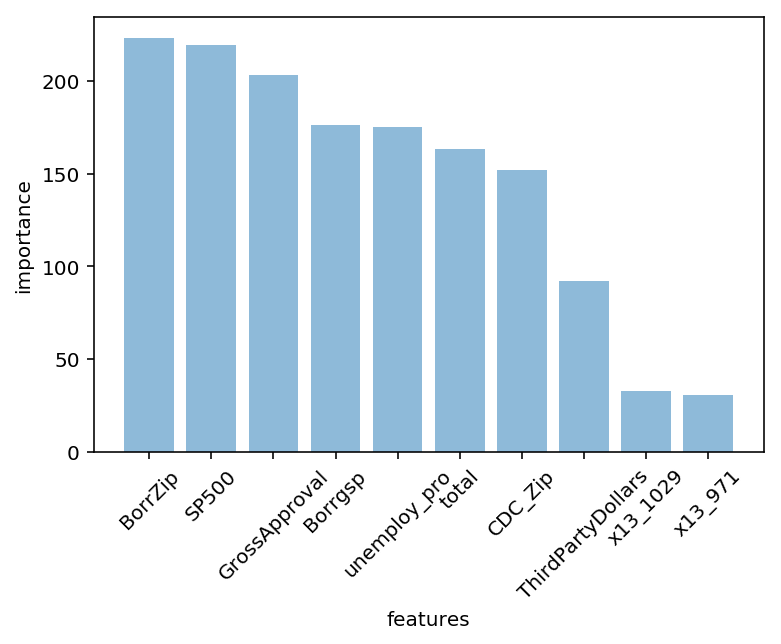

In [41]:
axis = list(zip(*fm1))[0]
yaxis = list(zip(*fm1))[1]
plt.bar(axis,yaxis,align='center', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.xticks(rotation=45)

#### Oversampling

##### 1. Random Oversampling

In [44]:
ros = RandomOverSampler(random_state=0, sampling_strategy = 0.3)
X_resampled, y_resampled = ros.fit_resample(train_X, train_y)
#X_resampled = pd.DataFrame(X_resampled, columns=train_X.columns)


In [45]:
modelC, pred_val_y = run_lgbc(X_resampled, y_resampled, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.324361
[200]	valid_0's binary_logloss: 0.323433
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.323299
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7344
           1       0.60      0.52      0.55      1411

   micro avg       0.87      0.87      0.87      8755
   macro avg       0.75      0.72      0.74      8755
weighted avg       0.86      0.87      0.86      8755

0.8527754327575584


In [46]:
print(classification_report(test_y, modelC.predict(test_X)>0.5))
print(roc_auc_score(test_y, modelC.predict(test_X)))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      9160
           1       0.62      0.50      0.55      1783

   micro avg       0.87      0.87      0.87     10943
   macro avg       0.76      0.72      0.74     10943
weighted avg       0.86      0.87      0.86     10943

0.8568214603227473


##### 2. SMOTE

In [47]:
sm = SMOTE(random_state=0, sampling_strategy = 0.3)
X_smote, y_smote = sm.fit_resample(train_X, train_y)
#X_smote = pd.DataFrame(X_smote, columns=train_X.columns)
#print('Original dataset shape %s' % Counter(train_y))
#print('SMOTE dataset shape %s' % Counter(y_smote))

In [48]:
modelC, pred_val_y = run_lgbc(X_smote, y_smote, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.316892
[200]	valid_0's binary_logloss: 0.315977
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.315672
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      7344
           1       0.64      0.43      0.52      1411

   micro avg       0.87      0.87      0.87      8755
   macro avg       0.77      0.69      0.72      8755
weighted avg       0.86      0.87      0.86      8755

0.8531362570620815


In [49]:
print(classification_report(test_y, modelC.predict(test_X)>0.5))
print(roc_auc_score(test_y, modelC.predict(test_X)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      9160
           1       0.67      0.42      0.51      1783

   micro avg       0.87      0.87      0.87     10943
   macro avg       0.78      0.69      0.72     10943
weighted avg       0.86      0.87      0.86     10943

0.8565702094257508


### Decision Tree

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
pipelines = {
    "dtclass": make_pipeline(DecisionTreeClassifier(random_state=0))
}
decisiontree_hyperparameters = {
    'decisiontreeclassifier__max_depth' : np.arange(3, 10),
    'decisiontreeclassifier__max_features' : np.arange(3, 8),
    'decisiontreeclassifier__min_samples_split' : np.arange(2, 15),
    "decisiontreeclassifier__min_samples_leaf" : np.arange(1,3)
}
dtclass_model = RandomizedSearchCV(pipelines['dtclass'],decisiontree_hyperparameters,n_iter = 100,cv=3, scoring = 'roc_auc')
dtclass_model.fit(train_X, train_y)
print(dtclass_model.best_params_)

{'decisiontreeclassifier__min_samples_split': 3, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_features': 6, 'decisiontreeclassifier__max_depth': 5}


In [43]:
dtclass_best_model = dtclass_model.best_estimator_.named_steps['decisiontreeclassifier']
print(classification_report(val_y, dtclass_best_model.predict(val_X)>0.5))
print(roc_auc_score(val_y, dtclass_best_model.predict(val_X)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7344
           1       0.57      0.40      0.47      1411

   micro avg       0.86      0.86      0.86      8755
   macro avg       0.73      0.67      0.70      8755
weighted avg       0.84      0.86      0.85      8755

0.6734716644355199


In [ ]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus as pdot
#writing the dot data
dot_data = StringIO()
#export the decision tree along with the feature names into a dot file format
export_graphviz(dtclass_best_model,out_file=dot_data,filled=True,special_characters=True,rounded=True,
                feature_names=train_X.columns.values,class_names = ["No","Yes"])
#make a graph from dot file
graph = pdot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Random Forest

In [172]:
data_scaler = StandardScaler()
train_num = data_scaler.fit_transform(train_X[numCols])
val_num = data_scaler.transform(val_X[numCols])
test_num = data_scaler.transform(test_X[numCols])
train_num_df = pd.DataFrame(train_num,columns = numCols)[num_select2]
train_num_df = train_num_df.reset_index(drop=True)
val_num_df = pd.DataFrame(val_num,columns = numCols)[num_select2]
val_num_df = val_num_df.reset_index(drop=True)
test_num_df = pd.DataFrame(test_num,columns = numCols)[num_select2]
test_num_df = test_num_df.reset_index(drop=True)

train_cat = train_X[catCols]
one_hot = OneHotEncoder(handle_unknown='ignore')
one_hot.fit(train_cat)
feature_names = [str(i) for i in list(one_hot.get_feature_names())]
for i in range(4):
    if i == 0:
        train_piece = one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds2]
        val_piece = one_hot.transform(val_X[catCols]).toarray()[:,inds2]
        test_piece = one_hot.transform(test_X[catCols]).toarray()[:,inds2]    
    elif i == 3:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[30000:]).toarray()[:,inds2]))      
    else:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds2]))

train_cat_df = pd.DataFrame(train_piece,columns = cat_select2)
val_cat_df = pd.DataFrame(val_piece,columns = cat_select2)
test_cat_df = pd.DataFrame(test_piece,columns = cat_select2)
newcatCols = list(train_cat_df.columns)

DNNtrain_X = pd.concat([train_num_df,train_cat_df],axis = 1)
DNNval_X = pd.concat([val_num_df,val_cat_df],axis = 1)
DNNtest_X = pd.concat([test_num_df,test_cat_df],axis = 1)

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  af

In [173]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=0), param_distributions = random_grid, n_iter = 20, cv = 3, verbose=1, random_state=0)
rf_random.fit(DNNtrain_X, train_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': [20, 73, 126, 180, 233, 286, 340, 393, 446, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [174]:
print(rf_random.best_params_)

{'n_estimators': 446, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [65]:
clf = RandomForestClassifier(n_estimators=500,random_state=0,min_samples_split=10)
clf.fit(train_X, train_y)
print(classification_report(val_y, clf.predict(val_X)>0.5))
print(roc_auc_score(val_y, clf.predict(val_X)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      7344
           1       0.67      0.38      0.49      1411

   micro avg       0.87      0.87      0.87      8755
   macro avg       0.78      0.67      0.71      8755
weighted avg       0.85      0.87      0.86      8755

0.6738161797516865


In [68]:
preds_rf = clf.predict(test_X)

## DNN

In [195]:
%run DNN_utils.py

<Figure size 432x288 with 0 Axes>

In [196]:
# try to drop features 
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numCols1)])
DNNtrain_X = preprocessor.fit_transform(train_X1)
DNNval_X = preprocessor.transform(val_X1)
DNNtest_X = preprocessor.transform(test_X1)

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [197]:
#read your data in, remeber to use one_hot_encoding for your Y, otherwise TF will not work
#DNNtrain_X = DNNtrain_X.T.as_matrix()
#DNNval_X = DNNval_X.T.as_matrix()
DNNtrain_X = DNNtrain_X.T
DNNval_X = DNNval_X.T
DNNtest_X = DNNtest_X.T
DNNtrain_y = np.array(train_y).reshape(1,-1)
DNNval_y = np.array(val_y).reshape(1,-1)
DNNtest_y = np.array(test_y).reshape(1,-1)
DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
DNNval_y = convert_to_one_hot(DNNval_y, 2)
DNNtest_y = convert_to_one_hot(DNNtest_y, 2)

In [ ]:
# drop after one hot 
DNNtrain_X = gbtrain_X.T.as_matrix()
DNNval_X = gbval_X.T.as_matrix()
DNNtest_X = gbtest_X.T.as_matrix()
DNNtrain_y = np.array(train_y).reshape(1,-1)
DNNval_y = np.array(val_y).reshape(1,-1)
DNNtest_y = np.array(test_y).reshape(1,-1)
DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
DNNval_y = convert_to_one_hot(DNNval_y, 2)
DNNtest_y = convert_to_one_hot(DNNtest_y, 2)

In [ ]:
# drop twice after one hot
data_scaler = StandardScaler()
train_num = data_scaler.fit_transform(train_X[numCols])
val_num = data_scaler.transform(val_X[numCols])
test_num = data_scaler.transform(test_X[numCols])
train_num_df = pd.DataFrame(train_num,columns = numCols)[num_select2]
train_num_df = train_num_df.reset_index(drop=True)
val_num_df = pd.DataFrame(val_num,columns = numCols)[num_select2]
val_num_df = val_num_df.reset_index(drop=True)
test_num_df = pd.DataFrame(test_num,columns = numCols)[num_select2]
test_num_df = test_num_df.reset_index(drop=True)

train_cat = train_X[catCols]
one_hot = OneHotEncoder(handle_unknown='ignore')
one_hot.fit(train_cat)
feature_names = [str(i) for i in list(one_hot.get_feature_names())]
for i in range(4):
    if i == 0:
        train_piece = one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds2]
        val_piece = one_hot.transform(val_X[catCols]).toarray()[:,inds2]
        test_piece = one_hot.transform(test_X[catCols]).toarray()[:,inds2]    
    elif i == 3:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[30000:]).toarray()[:,inds2]))      
    else:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds2]))

train_cat_df = pd.DataFrame(train_piece,columns = cat_select2)
val_cat_df = pd.DataFrame(val_piece,columns = cat_select2)
test_cat_df = pd.DataFrame(test_piece,columns = cat_select2)
newcatCols = list(train_cat_df.columns)

DNNtrain_X = pd.concat([train_num_df,train_cat_df],axis = 1).T.as_matrix()
DNNval_X = pd.concat([val_num_df,val_cat_df],axis = 1).T.as_matrix()
DNNtest_X = pd.concat([test_num_df,test_cat_df],axis = 1).T.as_matrix()

DNNtrain_y = np.array(train_y).reshape(1,-1)
DNNval_y = np.array(val_y).reshape(1,-1)
DNNtest_y = np.array(test_y).reshape(1,-1)
DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
DNNval_y = convert_to_one_hot(DNNval_y, 2)
DNNtest_y = convert_to_one_hot(DNNtest_y, 2)

In [ ]:
data_scaler = StandardScaler()
train_num = data_scaler.fit_transform(train_X1[numCols1])
val_num = data_scaler.transform(val_X1[numCols1])
test_num = data_scaler.transform(test_X1[numCols1])
train_num_df = pd.DataFrame(train_num,columns = numCols1)
train_num_df.reset_index(inplace=True)
val_num_df = pd.DataFrame(val_num,columns = numCols1)
val_num_df.reset_index(inplace=True)
test_num_df = pd.DataFrame(test_num,columns = numCols1)
test_num_df.reset_index(inplace=True)

one_hot = OneHotEncoder(handle_unknown='ignore')
train_cat = one_hot.fit_transform(train_X1[catCols1]).toarray()
train_cat_df.reset_index(inplace=True)
val_cat = one_hot.transform(val_X1[catCols1]).toarray()
val_cat_df.reset_index(inplace=True)
test_cat = one_hot.transform(test_X1[catCols1]).toarray()
test_cat_df.reset_index(inplace=True)
feature_names = [str(i) for i in list(one_hot.get_feature_names())]
train_cat_df = pd.DataFrame(train_cat,columns = feature_names)
val_cat_df = pd.DataFrame(val_cat,columns = feature_names)
test_cat_df = pd.DataFrame(test_cat,columns = feature_names)
newcatCols = list(train_cat_df.columns)

DNNtrain_X = pd.concat([train_num_df,train_cat_df],axis = 1)
DNNval_X = pd.concat([val_num_df,val_cat_df],axis = 1)
DNNtest_X = pd.concat([test_num_df,test_cat_df],axis = 1)

In [9]:
# try to drop features 
#DNNtrain_X = train_X1.T.as_matrix()
#DNNval_X = val_X1.T.as_matrix()
#DNNtrain_y = np.array(train_y1).reshape(1,-1)
#DNNval_y = np.array(val_y1).reshape(1,-1)
#DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
#DNNval_y = convert_to_one_hot(DNNval_y, 2)

Cost after epoch 0: 1.923399
Cost after epoch 100: 0.380495
Cost after epoch 200: 0.377867


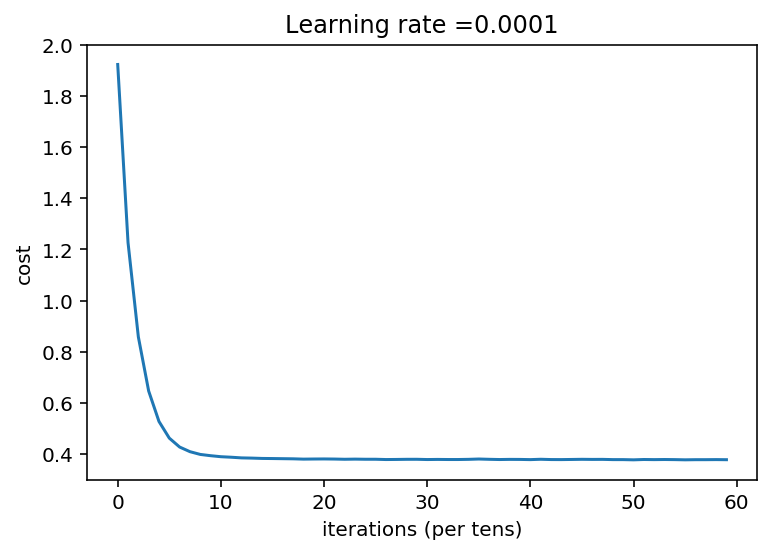

Parameters have been trained!
Train Accuracy: 0.8528715
Test Accuracy: 0.850257


In [216]:
num1 = DNNtrain_X.shape[0]
parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = 0.0001, keep_prob=0.9,lamb=0.01,num_epochs = 300, minibatch_size=512, params = [256,128,64,2],layer=4)

In [217]:
default_prob = get_probability(parameters, DNNval_X, layer=4)[1,:]
roc_auc_score(DNNval_y[1,:], default_prob)

0.8168512187928955

In [218]:
default_prob = get_probability(parameters, DNNtest_X, layer=4)[1,:]
roc_auc_score(DNNtest_y[1,:], default_prob)

0.8138277999152598

Cost after epoch 0: 2.413918
Cost after epoch 100: 0.380218
Cost after epoch 200: 0.377667


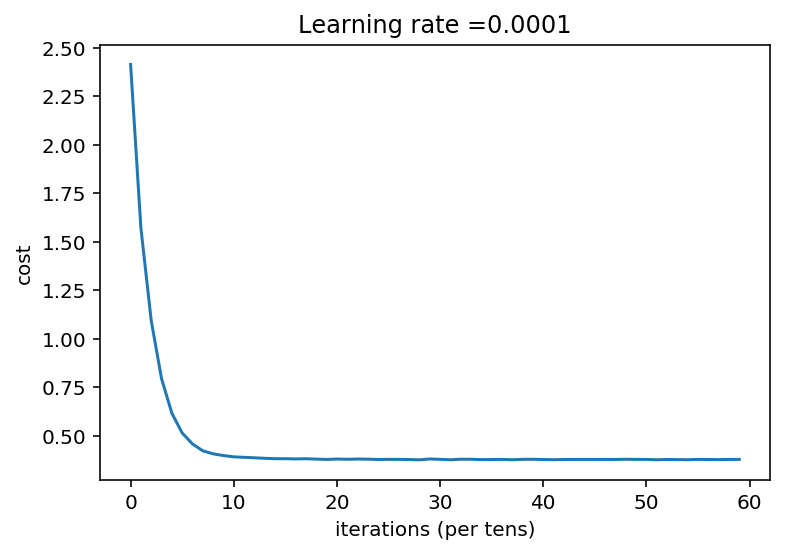

Parameters have been trained!
Train Accuracy: 0.8529857
Test Accuracy: 0.8520845


In [219]:
num1 = DNNtrain_X.shape[0]
parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = 0.0001, keep_prob=0.9,lamb=0.01,num_epochs = 300, minibatch_size=1024, params = [512,256,2],layer=3)

In [214]:
default_prob = get_probability(parameters, DNNval_X,layer=3)[1,:]
roc_auc_score(DNNval_y[1,:], default_prob)

0.8162463386803654

In [215]:
default_prob = get_probability(parameters, DNNtest_X,layer=3)[1,:]
roc_auc_score(DNNtest_y[1,:], default_prob)

0.8133608718439801

In [59]:
print(classification_report(DNNtest_y[1,:], default_prob>0.5))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      9160
         1.0       0.65      0.23      0.34      1783

   micro avg       0.85      0.85      0.85     10943
   macro avg       0.76      0.60      0.63     10943
weighted avg       0.83      0.85      0.82     10943



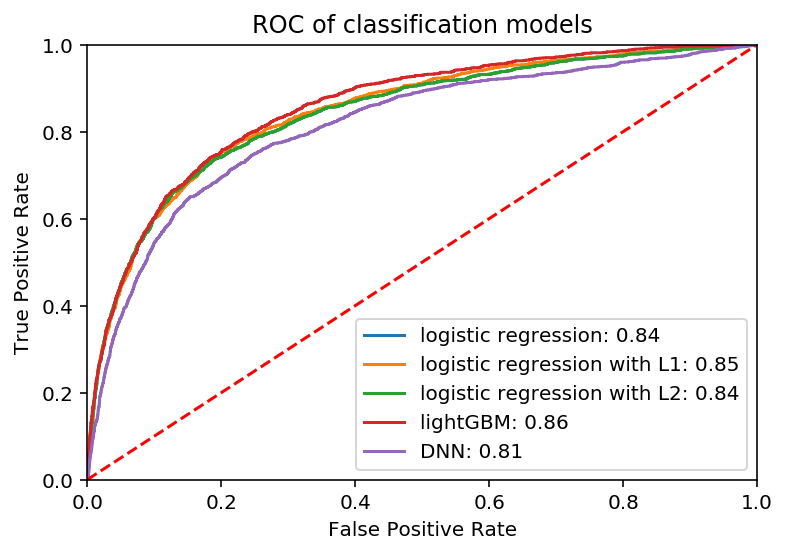

In [237]:
# ROC of all models

plt.title('ROC of classification models')
fpr, tpr, threshold = metrics.roc_curve(test_y, preds_log)
roc_auc1 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'logistic regression: %0.2f' % roc_auc1)

fpr, tpr, threshold = metrics.roc_curve(test_y, preds_log_l1)
roc_auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'logistic regression with L1: %0.2f' % roc_auc2)

fpr, tpr, threshold = metrics.roc_curve(test_y, preds_log_l2)
roc_auc3 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'logistic regression with L2: %0.2f' % roc_auc3)

fpr, tpr, threshold = metrics.roc_curve(test_y, preds_lgbm)
roc_auc4 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'lightGBM: %0.2f' % roc_auc4)

fpr, tpr, threshold = metrics.roc_curve(test_y, default_prob)
roc_auc5 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'DNN: %0.2f' % roc_auc5)

#fpr, tpr, threshold = metrics.roc_curve(test_y, preds_rf)
#roc_auc6 = metrics.auc(fpr, tpr)
#plt.plot(fpr, tpr, label = 'random forest: %0.2f'% roc_auc6)


plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [ ]:
# grid search cross validation
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M',
                    filename='E:/MS&E 246 Financial Risk Analytics/project/DNN.log', # change it to your local directory!
                    filemode='w')
param_names = ['learning_rate','keep_prob','lamb','num_epochs','minibatch_size','params','layer']
param_list = [[0.00001,0.0001,0.01,0.1],[1,0.9,0.8],[0.01,0.1,1],[300,500],[256,512,1024],[[128,64,2],[64,32,2],[256,128,2],[256,64,2],[512,256,2],[512,128,2]],[3]]
param_sets = list(itertools.product(*param_list))
param_select = []
randinds = [i for i in range(len(param_sets))]
random.shuffle(randinds)
for i in range(500):
    param_select.append(param_sets[randinds[i]])
auc_list = []
num1 = DNNtrain_X.shape[0]
for i in range(500):
    if i%50 == 0:
        logging.info('Iteration {}',format(i))
        logging.info('Best AUC for now: {}'.format(max(auc_list)))
    p = param_select[i]
    print(list(zip(param_names,p)))
    logging.info(list(zip(param_names,p)))
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = p[0], keep_prob = p[1], lamb = p[2],num_epochs = p[3],minibatch_size = p[4], params = p[5],layer = p[6])
    default_prob = get_probability(parameters, DNNval_X,layer=3)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    auc_list.append(auc)
    print(auc)
    logging.info('AUC: {}'.format(auc))
    print('----------------------------')
maxauc = max(auc_list)
bestparams = param_select[auc_list.index(maxauc)]
print('Best parameters: {}'.format(list(zip(param_names,bestparams))))
logging.info('Best parameters: {}'.format(list(zip(param_names,bestparams))))
print('Best AUC: {}'.format(maxauc))
logging.info('Best AUC: {}'.format(maxauc))

In [ ]:
# step-wise validation
num1 = DNNtrain_X.shape[0]
learning_rates = [0.00001,0.0001,0.01,0.1]
params_all = [[100,50,2],[128,64,2],[64,32,2],[256,128,2],[256,64,2],[512,256,2],[512,128,2]]
keep_probs = [1,0.9,0.8]
lambs = [0.01,0.1,1,10]
minibatch_sizes = [256,512,1024]
epochs = [400,500,600]

aucl = []
for l in learning_rates:
    print('choose learning rate')
    print(l)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate=l)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucl.append(auc)
    print(auc)
    print('----------------------------')
maxaucl = max(aucl)
bestl = learning_rates[aucl.index(maxaucl)]
print('Best learning rate: {}'.format(bestl))
print('Best AUC: {}'.format(maxaucl))

auck = []
for k in keep_probs:
    print('choose dropout prob')
    print(k)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = k)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    auck.append(auc)    
    print(auc)
    print('----------------------------')
maxauck = max(auck)
bestk = keep_probs[auck.index(maxauck)]
print('Best dropout prob: {}'.format(bestk))
print('Best AUC: {}'.format(maxauck))


aucp = []
for p in params_all:
    print('choose # nodes')
    print(p)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, params = p)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucp.append(auc)    
    print(auc)
    print('----------------------------')    
maxaucp = max(aucp)
bestp = params_all[aucp.index(maxaucp)]
print('Best # nodes: {}'.format(bestp))
print('Best AUC: {}'.format(maxaucp))


aucla = []    
for la in lambs:
    print('choose regularization param')
    print(la)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = la, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucla.append(auc)    
    print(auc)
    print('----------------------------')
maxaucla = max(aucla)
bestla = lambs[aucla.index(maxaucla)]
print('Best regularization param: {}'.format(bestla))
print('Best AUC: {}'.format(maxaucla))

aucmi = []
for mi in minibatch_sizes:
    print('choose minibatch size')
    print(mi)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = bestla,minibatch_size = mi, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucmi.append(auc)  
    print(auc)
    print('----------------------------')
maxaucmi = max(aucmi)
bestmi = minibatch_sizes[aucmi.index(maxaucmi)]
print('Best minibatch sizes: {}'.format(bestmi))
print('Best AUC: {}'.format(maxaucmi))

auce = []
for e in epochs:
    print('choose # epochs')
    print(e)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = bestla,num_epochs = e,minibatch_size = mi, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    auce.append(auc)  
    print(auc)
    print('----------------------------')
maxauce = max(auce)
beste = minibatch_sizes[auce.index(maxauce)]
print('Best # epochs: {}'.format(beste))
print('Best AUC: {}'.format(maxauce))   


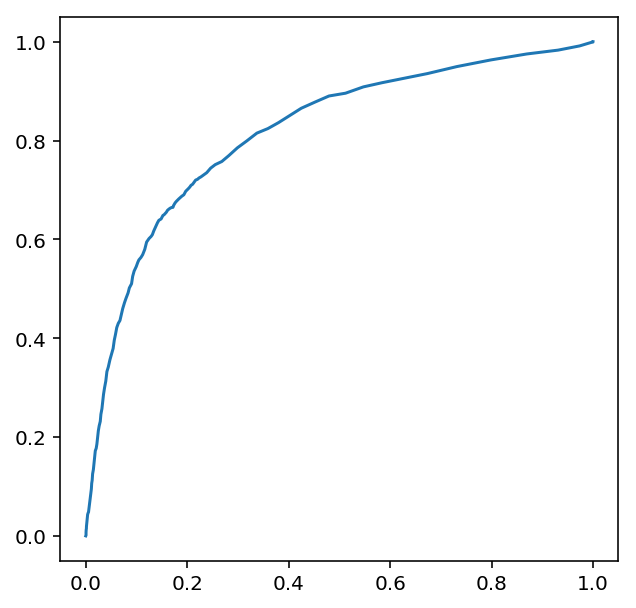

In [71]:
default_prob = get_probability(parameters, DNNval_X)[1,:]
n = 200
TPR = np.zeros((n,1))
FPR = np.zeros((n,1))
t = np.linspace(0.0, 1.0, n)
for i in range(n):
    TPR[i,0], FPR[i,0] = get_ROC(default_prob,t[i],DNNval_y[1,:])
plt.figure(figsize=(5,5))
plt.plot(FPR, TPR)

## Regression

In [121]:
regdata = rawdata[rawdata['target'] == 1]
# split the data
#y_reg = np.log(regdata['GrossChargeOffAmount'].values + 1)
# predict percentage
y_reg = regdata['severity'].values
X_reg = regdata[numCols+['age']+catCols]
train_X_reg, test_X_reg, train_y_reg, test_y_reg = train_test_split(X_reg,y_reg,test_size=0.2,random_state=1)
train_X_reg, val_X_reg, train_y_reg, val_y_reg = train_test_split(train_X_reg,train_y_reg,test_size=0.2,random_state=1)


### Linear Regression

In [73]:
starttime = time.time()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])
lr.fit(train_X_reg, train_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_reg, lr.predict(val_X_reg))))


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


time: 5.877509355545044
0.655714797820392


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [74]:
print(np.sqrt(metrics.mean_squared_error(test_y_reg, lr.predict(test_X_reg))))

0.6820807587769433


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Lasso

In [75]:
from sklearn.linear_model import Lasso
alphas = [0.01,0.05,0.1,0.2]
for a in alphas:
    print('alpha: {}'.format(a))
    lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  Lasso(alpha = a))])
    lasso.fit(train_X_reg, train_y_reg)
    print(np.sqrt(metrics.mean_squared_error(val_y_reg, lasso.predict(val_X_reg))))
    


alpha: 0.01


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.21337663941896537
alpha: 0.05


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Pytho

0.22812562276596624
alpha: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.2309741424196447
alpha: 0.2
0.2309741424196447


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [76]:
starttime = time.time()
lasso = Pipeline(steps=[('preprocessor', preprocessor),
                  ('regressor',  Lasso(alpha = 0.01))])
lasso.fit(train_X_reg, train_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(test_y_reg, lasso.predict(test_X_reg))))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


time: 7.998261213302612
0.20551640224992707


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Ridge

In [77]:
alphas = [0.01,0.1,0.2,0.5]
for a in alphas:
    print('alpha: {}'.format(a))
    ridge = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  Ridge(alpha = a))])
    ridge.fit(train_X_reg, train_y_reg)
    print(np.sqrt(metrics.mean_squared_error(val_y_reg, ridge.predict(val_X_reg))))

alpha: 0.01


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Pytho

0.21480037137071814
alpha: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.21395264022497254
alpha: 0.2


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.21315342209706678
alpha: 0.5
0.21122523222836495


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [78]:
starttime = time.time()
ridge = Pipeline(steps=[('preprocessor', preprocessor),
                  ('regressor',  Ridge(alpha = 0.5))])
ridge.fit(train_X_reg, train_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(test_y_reg, ridge.predict(test_X_reg))))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


time: 3.0557010173797607
0.20810212732902234


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Elastic Net

In [79]:
from sklearn.linear_model import ElasticNet
alphas = [0.01,0.05,0.1,0.2]
ratios = [0.1,0.3,0.5,0.7,0.9]
for a in alphas:
    for r in ratios:
        print('alpha: {}'.format(a))
        print('l1 ratio: {}'.format(r))
        elastic = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor',  ElasticNet(alpha = a,l1_ratio = r))])
        elastic.fit(train_X_reg, train_y_reg)
        print(np.sqrt(metrics.mean_squared_error(val_y_reg, elastic.predict(val_X_reg))))

alpha: 0.01
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Pytho

0.2048976680561075
alpha: 0.01
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.20774105682853275
alpha: 0.01
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.2096557987517757
alpha: 0.01
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.21158752262870018
alpha: 0.01
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.21292536350407673
alpha: 0.05
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.21064815384120691
alpha: 0.05
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.2160499862295508
alpha: 0.05
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.21982600745028902
alpha: 0.05
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.22523488041937667
alpha: 0.05
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.22713767579627195
alpha: 0.1
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.21497490063487934
alpha: 0.1
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.22291638543555342
alpha: 0.1
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.2282474633550291
alpha: 0.1
l1 ratio: 0.7
0.2309741424196447
alpha: 0.1
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.2309741424196447
alpha: 0.2
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Pytho

0.2196481441846538
alpha: 0.2
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.23051492525741088
alpha: 0.2
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.2309741424196447
alpha: 0.2
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.2309741424196447
alpha: 0.2
l1 ratio: 0.9
0.2309741424196447


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [80]:
starttime = time.time()
elastic = Pipeline(steps=[('preprocessor', preprocessor),
                  ('regressor',  ElasticNet(alpha = 0.01,l1_ratio = 0.1))])
elastic.fit(train_X_reg, train_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(test_y_reg, elastic.predict(test_X_reg))))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


time: 13.618904829025269
0.1936318011214605


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### LightGBM

In [10]:
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 10,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    lgb.plot_importance(model)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.173612
[200]	valid_0's rmse: 0.173001
Early stopping, best iteration is:
[184]	valid_0's rmse: 0.172804
time: 0.4448401927947998
0.17280353193539463


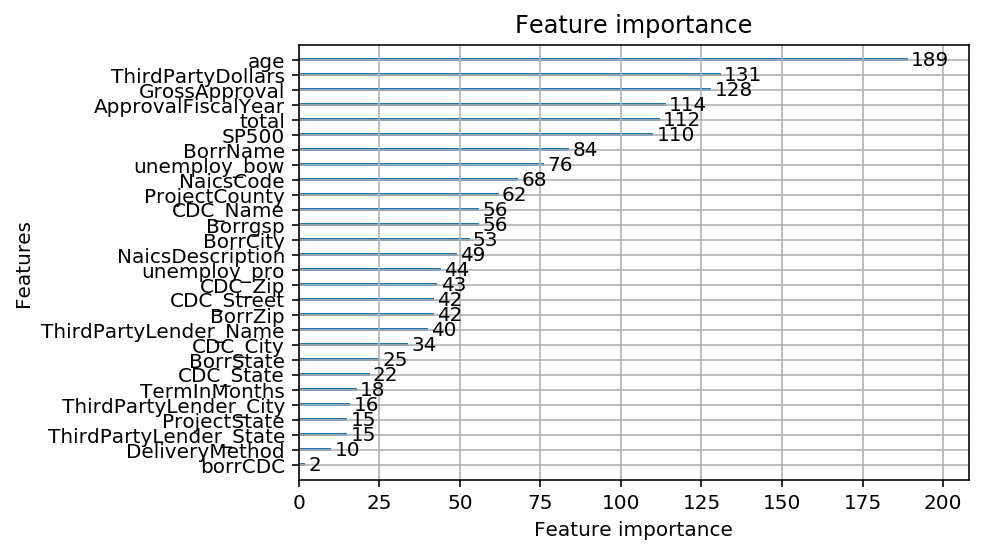

In [193]:
starttime = time.time()
modelR, pred_val_y = run_lgb(train_X_reg, train_y_reg, val_X_reg, val_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_reg, pred_val_y)))

In [83]:
#modelR, pred_test_y = run_lgb(train_X_reg, train_y_reg, test_X_reg, test_y_reg)
pred_test_y = modelR.predict(test_X_reg)
print(np.sqrt(metrics.mean_squared_error(test_y_reg, pred_test_y)))

0.1635935221916099


In [14]:
# try to implement with pipeline

class LGBM_Regressor:
    def fit(self, train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y
        return self
    def fit_predict(self,val_X,val_y):
        params = {
            "objective" : "regression",
            "metric" : "rmse", 
            "num_leaves" : 10,
            "min_child_samples" : 100,
            "learning_rate" : 0.1,
            "bagging_fraction" : 0.7,
            "feature_fraction" : 0.5,
            "bagging_frequency" : 5,
            "bagging_seed" : 2018,
        }

        lgtrain = lgb.Dataset(self.train_X, label=self.train_y)
        lgval = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
        pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
        return model, pred_val_y
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols+['age']),
                                               ('cat', categorical_transformer, catCols)])
lgbr = Pipeline(steps=[('preprocessor', preprocessor),
                  ('regressor',  LGBM_Regressor())])
lgbr.fit(train_X_reg,train_y_reg)
modelR, pred_val_y = lgbr.fit_predict(val_X_reg, val_y_reg)
print(np.sqrt(metrics.mean_squared_error(val_y_reg, pred_val_y)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.1868
[200]	valid_0's rmse: 0.187073
Early stopping, best iteration is:
[123]	valid_0's rmse: 0.186233
0.18623281314019835


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

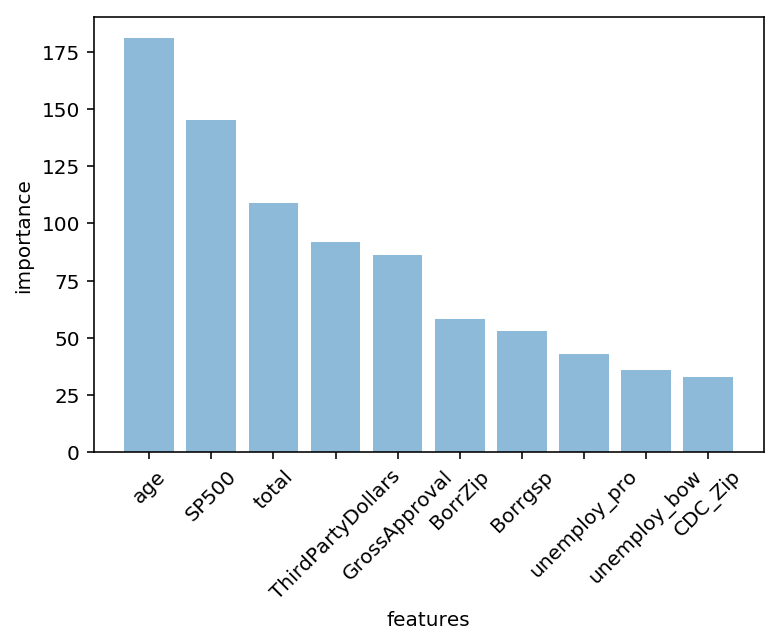

In [34]:
feature_names = get_column_names_from_ColumnTransformer(lgbr.named_steps['preprocessor'])
fn = modelR.feature_name()
fi = list(modelR.feature_importance())
fm = list(zip(fn,fi))
fm1 = sorted(fm,key=lambda x:x[1],reverse =True)[:10]
axis = list(zip(*fm1))[0]
axis = [int(i[7:]) for i in axis]
xaxis = [feature_names[i] for i in axis]
yaxis = list(zip(*fm1))[1]
plt.bar(xaxis,yaxis,align='center', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.xticks(rotation=45)

### Loss Prediction on the Best Model

In [134]:
# 1 year
samples['age'] = samples['age1']
pred_X1 = samples[numCols+['age']+catCols]
pred_loss1 = modelR.predict(pred_X1)

In [135]:
# 5 year
samples['age'] = samples['age5']
pred_X5 = samples[numCols+['age']+catCols]
pred_loss5 = modelR.predict(pred_X5)

In [136]:
np.savetxt('pred_loss1.txt',pred_loss1)
np.savetxt('pred_loss5.txt',pred_loss5)

### XGboost

In [86]:
def run_xgb(X_train, y_train, X_val, y_val, X_test, y_test):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train.values, y_train.values)
    xgb_val_data = xgb.DMatrix(X_val.values, y_val.values)
    xgb_test_data = xgb.DMatrix(X_test.values, y_test.values)
    #xgb_submit_data = xgb.DMatrix(X_test)
    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    y_pred_test = model.predict(xgb_test_data, ntree_limit=model.best_ntree_limit)
    #y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    return model, y_pred_val, y_pred_test

In [87]:
starttime = time.time()
xgb_model, xgb_preds_val, xgb_preds_test = run_xgb(train_X_reg, pd.DataFrame(train_y_reg), val_X_reg, pd.DataFrame(val_y_reg),test_X_reg, pd.DataFrame(test_y_reg))
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_reg, xgb_preds_val)))
print(np.sqrt(metrics.mean_squared_error(test_y_reg, xgb_preds_test)))

[0]	train-rmse:0.271677	valid-rmse:0.266682
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.201755	valid-rmse:0.216328
[1000]	train-rmse:0.158816	valid-rmse:0.191238
[1500]	train-rmse:0.132075	valid-rmse:0.179617
[1999]	train-rmse:0.114572	valid-rmse:0.174262
time: 31.536433935165405
0.17426189006024354
0.16749710504118964


### DNN Regressor

In [99]:
data_scaler = StandardScaler()
train_num_r = train_X_reg[numCols]
data_scaler.fit(train_num_r)
train_num_r = data_scaler.transform(train_num_r)
val_num_r = data_scaler.transform(val_X_reg[numCols])
test_num_r = data_scaler.transform(test_X_reg[numCols])
train_num_r_df = pd.DataFrame(train_num_r,columns = numCols)
train_num_r_df.reset_index(inplace=True)
val_num_r_df = pd.DataFrame(val_num_r,columns = numCols)
val_num_r_df.reset_index(inplace=True)
test_num_r_df = pd.DataFrame(test_num_r,columns = numCols)
test_num_r_df.reset_index(inplace=True)

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [102]:
one_hot = OneHotEncoder(handle_unknown='ignore')
train_cat_r = one_hot.fit_transform(train_X_reg[catCols]).toarray()
val_cat_r = one_hot.transform(val_X_reg[catCols]).toarray()
test_cat_r = one_hot.transform(test_X_reg[catCols]).toarray()
feature_names = [str(i) for i in list(one_hot.get_feature_names())]
train_cat_r_df = pd.DataFrame(train_cat_r,columns = feature_names)
train_cat_r_df.reset_index(inplace=True)
val_cat_r_df = pd.DataFrame(val_cat_r,columns = feature_names)
val_cat_r_df.reset_index(inplace=True)
test_cat_r_df = pd.DataFrame(test_cat_r,columns = feature_names)
test_cat_r_df.reset_index(inplace=True)
newcatCols = list(train_cat_r_df.columns)
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in numCols+newcatCols]

In [103]:
train_dnn_r = pd.concat([train_num_r_df,train_cat_r_df],axis = 1)
val_dnn_r = pd.concat([val_num_r_df,val_cat_r_df],axis = 1)
test_dnn_r = pd.concat([test_num_r_df,test_cat_r_df],axis = 1)

In [104]:
train_dnn_r.shape

(5748, 13309)

In [105]:
train_dnn_r_columns = list(train_dnn_r.columns)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {k: train_dnn_r[k].values for k in train_dnn_r_columns},
    y = train_y_reg,
    batch_size=512,
    num_epochs=500,
    shuffle=False,
)
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {k: val_dnn_r[k].values for k in train_dnn_r_columns},
    y = val_y_reg,
    batch_size=512,
    num_epochs=500,
    shuffle=False
)

In [106]:

regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols, 
                                          hidden_units=[256, 128], 
                                          #model_dir='./models/dnnregressor'
                                     )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\THINKPAD\\AppData\\Local\\Temp\\tmpqo_av6ng', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C8EA14F208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
regressor.train(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


## Simulation

In [137]:
total = list(samples['total'])
alltotal = sum(total)

In [138]:
import random
random.seed(0)
# year 1
allloss1 = []

for i in range(1000):
    simloss = []
    for j in range(500):
        rand =random.random()
        if rand <= pred_prob1[j]:
            simloss.append(pred_loss1[j]*total[j])
        else:
            simloss.append(0)
    allloss1.append(simloss)
sumloss1 = [sum(i)/alltotal*100 for i in allloss1]

Text(0.5, 1.0, 'distribution of 1 year % loss of loans of one simulation')

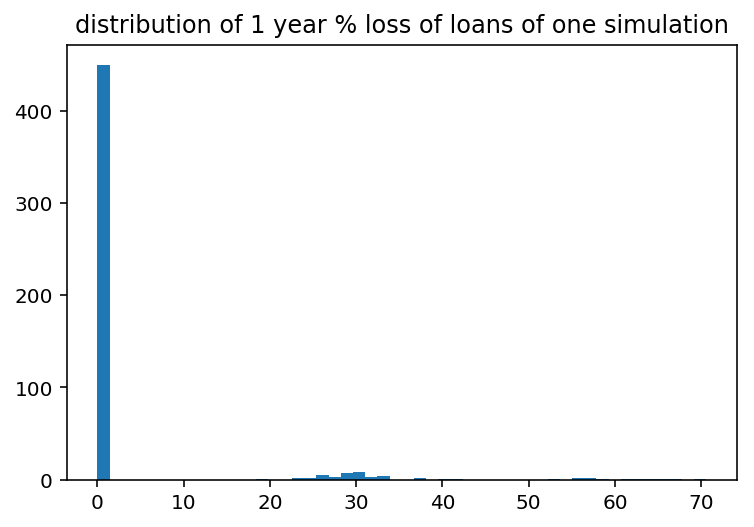

In [139]:
# distribution of 500 loans of one simulation
_,__,___ = plt.hist([allloss1[6][i]/total[i]*100 for i in range(500)],bins = 50)
plt.title('distribution of 1 year % loss of loans of one simulation')

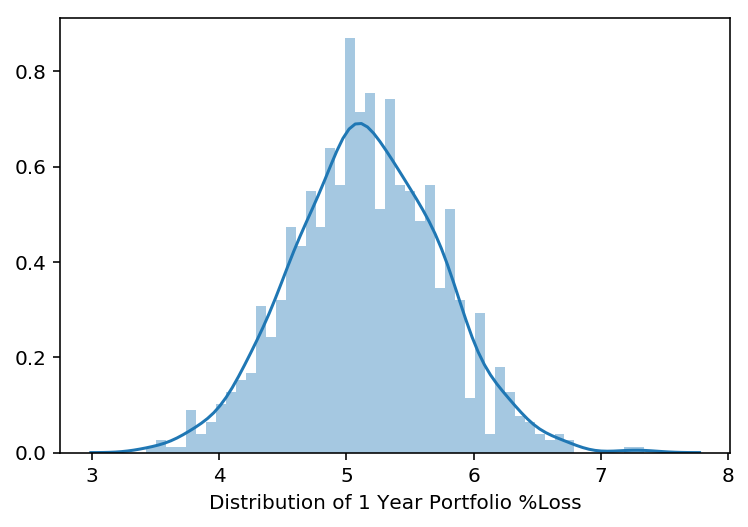

In [140]:
sns.distplot(sumloss1,bins = 50,axlabel = 'Distribution of 1 Year Portfolio %Loss')

In [141]:
# year 5
allloss5 = []
for i in range(1000):
    simloss = []
    for j in range(500):
        rand =random.random()
        if rand <= pred_prob5[j]:
            simloss.append(pred_loss5[j]*total[j])
        else:
            simloss.append(0)
    allloss5.append(simloss)
sumloss5 = [sum(i)/alltotal*100 for i in allloss5]

Text(0.5, 1.0, 'distribution of 5 year % loss of loans of one simulation')

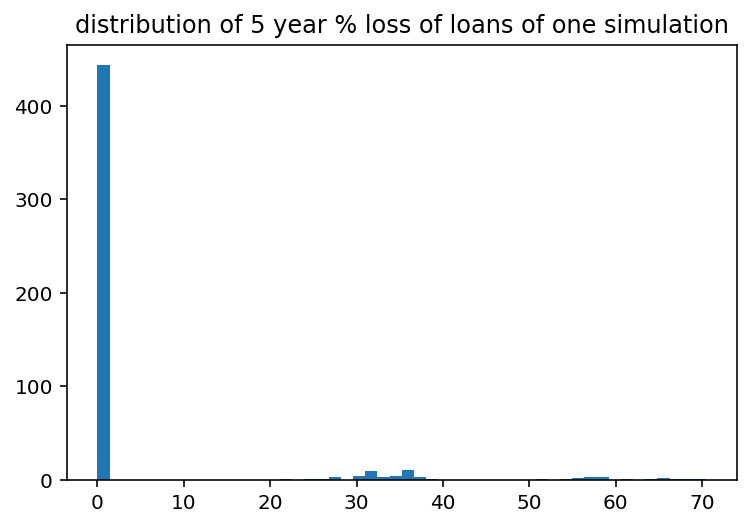

In [142]:
# distribution of 500 loans of one simulation
_,__,___ = plt.hist([allloss5[7][i]/total[i]*100 for i in range(500)],bins = 50)
plt.title('distribution of 5 year % loss of loans of one simulation')

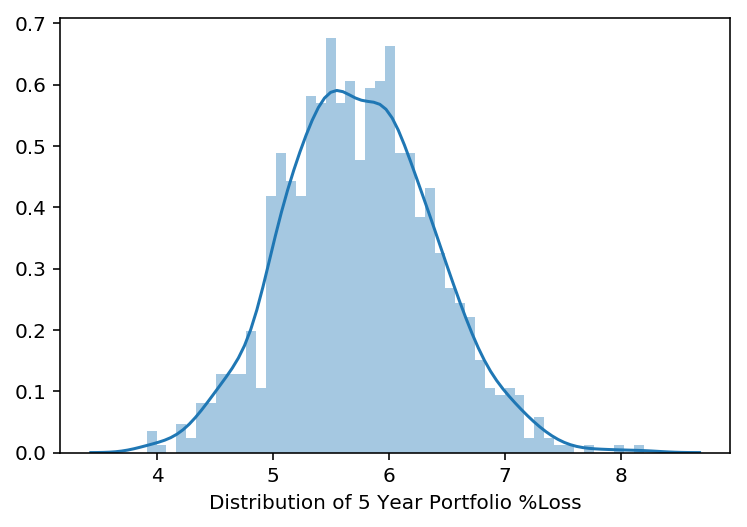

In [143]:
sns.distplot(sumloss5,bins = 50,axlabel = 'Distribution of 5 Year Portfolio %Loss')

## VaR

In [144]:
# year 1
sumloss1 = sorted(sumloss1)
# 95% VaR
var195 = sumloss1[950-1]
print('95% VaR: {}'.format(var195))
# 90% VaR
var190 = sumloss1[990-1]
print('99% VaR: {}'.format(var190))

95% VaR: 6.082324893041458
99% VaR: 6.556404364765831


In [145]:
# year 5
sumloss5 = sorted(sumloss5)
# 95% VaR
var595 = sumloss5[950-1]
print('95% VaR: {}'.format(var595))
# 90% VaR
var590 = sumloss5[990-1]
print('99% VaR: {}'.format(var590))

95% VaR: 6.812208193005478
99% VaR: 7.273951669917178


In [146]:
# Average VaR
# year 1
sumloss1 = sorted(sumloss1)
# 95% Average VaR
avar195 = 0
for i in range(0,50,10):
    avar195 += sumloss1[1000-i-1]*0.01
avar195 = avar195*(1/0.05)
print('95% Average VaR: {}'.format(avar195))
# 99% Average VaR
avar190 = 0
for i in range(0,10):
    avar190 += sumloss1[1000-i-1]*0.001
avar190 = avar190*(1/0.01)
print('99% Average VaR: {}'.format(avar190))

95% Average VaR: 6.538726170553596
99% Average VaR: 6.786111540761391


In [147]:
# Average VaR
# year 5
sumloss5 = sorted(sumloss5)
# 95% Average VaR
avar595 = 0
for i in range(0,50,10):
    avar595 += sumloss5[1000-i-1]*0.01
avar595 = avar595*(1/0.05)
print('95% Average VaR: {}'.format(avar595))
# 99% Average VaR
avar590 = 0
for i in range(0,10):
    avar590 += sumloss5[1000-i-1]*0.001
avar590 = avar590*(1/0.01)
print('99% Average VaR: {}'.format(avar590))

95% Average VaR: 7.294221810679656
99% Average VaR: 7.569378121332493


## Tranche

Text(0.5, 1.0, 'Distribution of 1 Year 5% - 15% Tranche Loss')

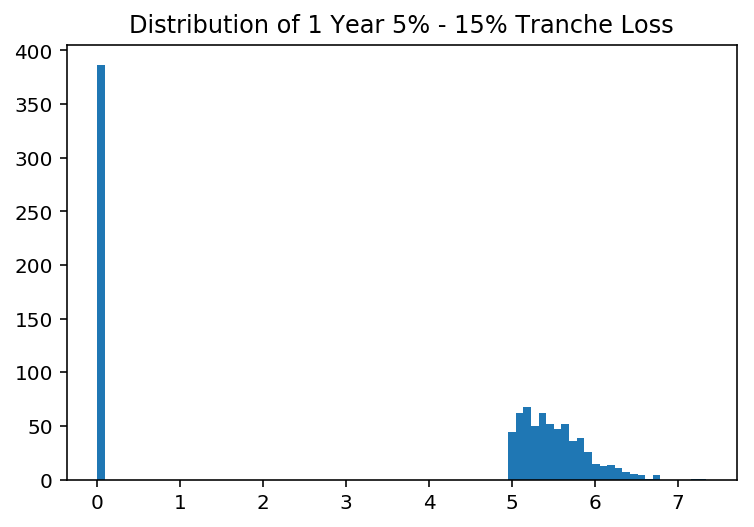

In [148]:
# 5% - 15%
# year 1
investor1 = []
for i in range(1000):
    if sumloss1[i] >= 5 and sumloss1[i] <= 15:
        investor1.append(sumloss1[i])
    else:
        investor1.append(0)
#sns.distplot(investor1,bins = 50,axlabel = 'Distribution of 1 Year 5% - 15% Tranche Loss')
_,__,___ = plt.hist(investor1,bins = 80)
plt.title('Distribution of 1 Year 5% - 15% Tranche Loss')

Text(0.5, 1.0, 'Distribution of 5 Year 5% - 15% Tranche Loss')

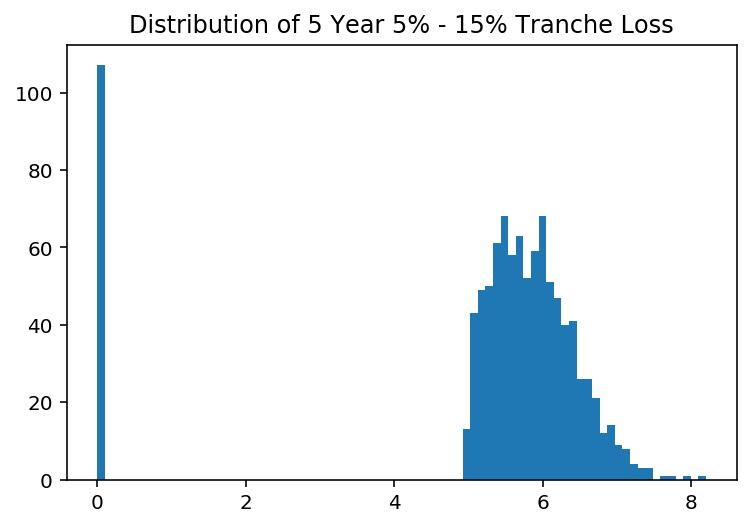

In [149]:
# year 5
investor5 = []
for i in range(1000):
    if sumloss5[i] >= 5 and sumloss5[i] <= 15:
        investor5.append(sumloss5[i])
    else:
        investor5.append(0)
#sns.distplot(investor5,bins = 50,axlabel = 'Distribution of 5 Year 5% - 15% Tranche Loss')
_,__,___ = plt.hist(investor5,bins = 80)
plt.title('Distribution of 5 Year 5% - 15% Tranche Loss')

Text(0.5, 1.0, 'Distribution of 1 Year 15% - 100% Tranche Loss')

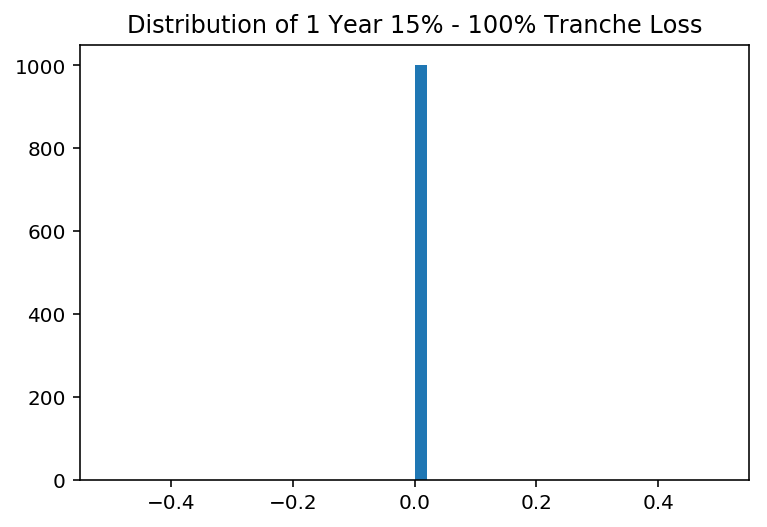

In [150]:
# 15% - 100%
# year 1
investor1 = []
for i in range(1000):
    if sumloss1[i] >= 15 and sumloss1[i] <= 100:
        investor1.append(sumloss1[i])
    else:
        investor1.append(0)
_,__,___ = plt.hist(investor1,bins = 50)
plt.title('Distribution of 1 Year 15% - 100% Tranche Loss')

Text(0.5, 1.0, 'Distribution of 5 Year 15% - 100% Tranche Loss')

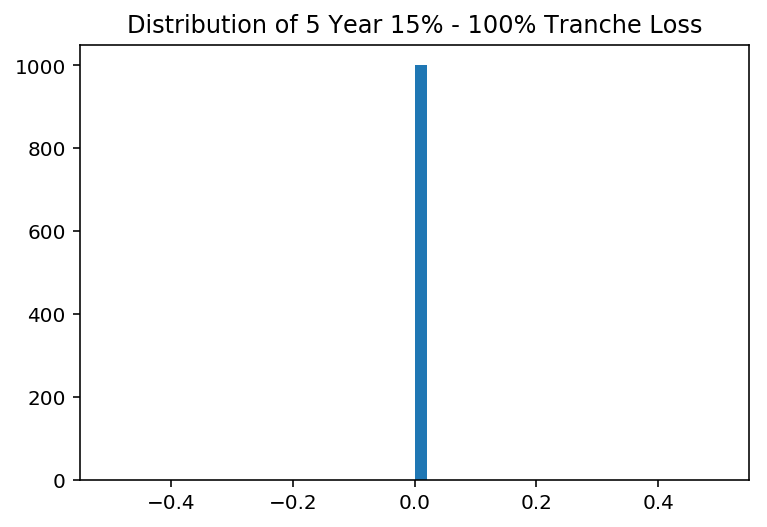

In [151]:
# year 5
investor5 = []
for i in range(1000):
    if sumloss5[i] >= 15 and sumloss5[i] <= 100:
        investor5.append(sumloss5[i])
    else:
        investor5.append(0)

_,__,___ = plt.hist(investor5,bins = 50)
plt.title('Distribution of 5 Year 15% - 100% Tranche Loss')